# Machine Learning Engineer Capstone Proposal

## Build a Stock Price Predictor 

### 1. Domain Background

Many investment firms have been using financial models for predicting stock prices to yield profits.  

#### 1.1 Random Walk Theory

Random walk theory states that the changes in stock prices are unpredictable regardless of the past movements which imply that the uncertainty of a stock price going up is equal to going down(Malkiel 1973; “Eugene Famaâs Efficient Market Hypothesis,” n.d.)(Malkiel 1973). This important financial theory got its name from a book (A Random Walk Down Wall Street) which was written by Burton Malkiel in 1973.

#### 1.2 Efficient Market Hypothesis

Random walk theory was later superseded and explained by the efficient market hy(Malkiel 1973)pothesis.  According to the efficient market hypothesis, it is impossible to "beat the market" because the stocks are priced accurately and reflect all available information (“Eugene Famaâs Efficient Market Hypothesis,” n.d.).   As per this hypothesis, investors are taking a gamble when they buy or sell a security as there is no guarantee they could buy a stock at a bargain price and sell at a much higher price to make a profit. This implies that investors have to buy a higher risk investment to make profits. However many investors (most notably Warren Buffet) have made profits consistently over a substantial span of time. 

#### 1.3 Fundamental Analysis

Fundamental Analysis is a complete top to the bottom approach where the analysts tend to study all factors that could influence the stock's value. They are the overall economy, country's economy, sector analysis and company analysis. With the help of fundamental analysis, investors should be able to compare the current price of a stock against their own calculated intrinsic value which could possibly give them a good indication of whether a stock is undervalued or overvalued.

#### 1.4 Technical Analysis

The purpose of doing technical analysis is to predict a stock's price based on its past movements. Technical analysis assumes that the fundamental analysis has already been accounted for a company's current stock price.  This type of investment strategy is generally used by short-term investors, where holding periods could range anywhere from seconds to weeks.

### 2. Problem Statement

To build a stock price predictor that makes use of past trading data to produce projected estimates. For this purpose, I would be using supervised learning regression algorithms because the output to be predicted is a continuous value. The dataset that would be used to develop the machine learning model will predict the Adjusted Close price of a stock, which is a numerical value. The prediction would be made for the next seven trading days.

### 3. Datasets and Inputs

The dataset would contain both metrics that we get directly from Quandl API  as a free user and derived metrics. Date, ticker, adjusted open, adjusted low, adjusted high, adjusted close are the metrics that we get from Quandl. Derived metrics are the technical indicators in our case as we are making use of technical analysis strategy for stock price prediction. There are two important types of indicators which are leading and lagging indicators.  We make use of TA-Lib library for calculating technical indicators. First, let us take a look at input metrics.

In [22]:
import numpy as np
import pandas as pd
import quandl
quandl.ApiConfig.api_key = "APIKEY"
from IPython.display import display
import arrow 


default_date_format = "YYYY-MM-DD" 
today = arrow.now()
start_date = today.replace(years=-3, days=-1).format(default_date_format)
end_date = today.replace(days=-1).format(default_date_format)
tickers = ["MSFT"]

columns = ["date", "ticker","adj_open", "adj_low", "adj_high", "adj_close"]
data = quandl.get_table("WIKI/PRICES", qopts = { "columns": columns }, ticker = tickers, date = { "gte": start_date, "lte": end_date })
data.index = data["date"].values
data.drop(["date", "ticker"], axis=1, inplace=True)
display(data.head())

,adj_open,adj_low,adj_high,adj_close
2015-03-02,40.767977,40.655951,41.253421,40.964022
2015-03-03,40.665287,40.226520,40.912677,40.403894
2015-03-04,40.151836,40.030475,40.338546,40.193846
2015-03-05,40.207849,39.974462,40.366552,40.245191
2015-03-06,40.142501,39.348986,40.245191,39.545031


755


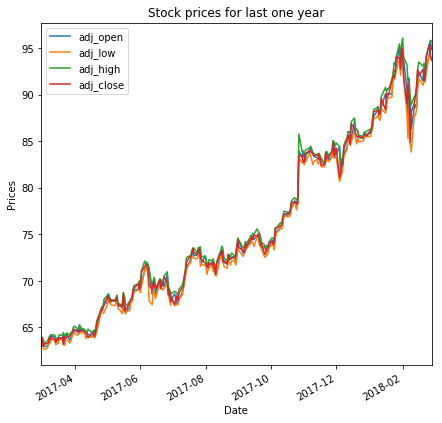

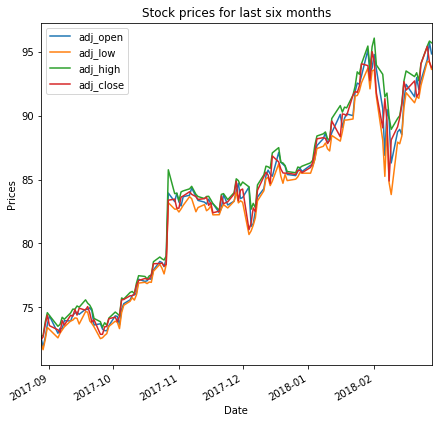

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7)

def plot_data(df, title="Stock prices", xlabel="Date", ylabel="Prices", kind='line'):
    ax = df.plot(title=title, kind=kind)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')
    plt.show()
    
print len(data)
# data for last one year
plot_data(data.tail(252), title="Stock prices for last one year")
# data for last six months 
plot_data(data.tail(126), title="Stock prices for last six months")

From the above graphs we can clearly all the four metrics follow each other closely, which indicates that the distribution of these would be similar. So, let'visualize the distribution for adjusted close price, by plotting a histogram.

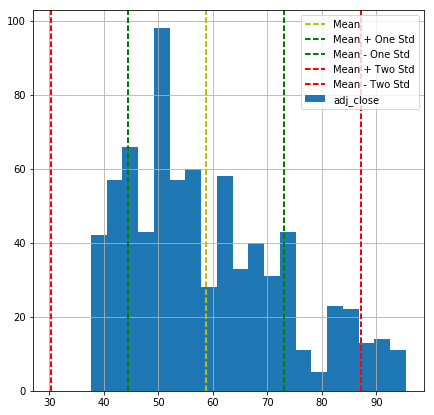

skewness = 0.684675223436
kurtosis = -0.378123268808


In [5]:
def plot_histogram(df, feature):
    df.hist(bins=20, label=feature)
    mean =  df.mean()
    std = df.std()
    kurt = df.kurtosis()
    skew = df.skew()
    plt.axvline(mean, color='y', linestyle='dashed', linewidth=2, label="Mean")
    plt.axvline(mean + std, color='g', linestyle='dashed', linewidth=2, label="Mean + One Std")
    plt.axvline(mean - std, color='g', linestyle='dashed', linewidth=2, label="Mean - One Std")
    plt.axvline(mean + (2 * std), color='r', linestyle='dashed', linewidth=2, label="Mean + Two Std")
    plt.axvline(mean - (2 * std), color='r', linestyle='dashed', linewidth=2, label="Mean - Two Std")
    plt.legend(loc='upper right')
    plt.show()
    print "skewness = {}".format(skew)
    print "kurtosis = {}".format(kurt)
# for col in data.columns.values:
plot_histogram(data["adj_close"], "adj_close")

From the result mentioned above we can see that adjusted close price is positively skewed. Skewness of 0.68 indicates that it's moderately skewed which implies that skewness could possibly increase if we add more data (increase number of years) suggesting that logarithmic transformation would be required to reduce the skewness. Kurtosis of normal distribution is considered as zero, however in this case we can see that -0.37 which is close to zero indicating that we have a distribution that does not require any transformation to make it more normalized. Low kurtosis value also indicates that we don't have fat tails. By looking at the histogram we can see that majority of our data is within two standard deviations from mean. Since we have a positively or left skewed distribution the right tail is larger than left which could be seen on the histogram where the right tail stretches beyond the 2 standard deviation mark. Hence, based on the visualization and results, I conclude that any of type transformation is not required for the above metrics, which we normally do if the data is highly skewed as the algorithms are very sensitive towards dataset with high level of skewness.

#### Leading and Lagging Indicators

Leading indicators are created to lead or move forward the price movements of a security thereby providing better predictive capabilities when compared to lagging indicators because lagging indicators follow the price movements/trends. Examples of leading indicators are momentum, commodity channel index, stochastic oscillator, RSI etc. Examples of lagging indicators are moving averages, Bollinger Bands, MACD etc. 

##### Momentum

Momentum measures the rate of change in price over a period of time indicating whether the price has increased which could mean its a positive momentum or decreased which could be considered as a negative momentum. Formula for calculating momentum is 

	Momentum[t]  =  price[t] /  price[t-n] - 1
    
 where, Momentum[t] and price[t]  is momentum and price (in our case we use adjusted close) on a particular day               price[t-n] is the price n days earlier. 
	
    
##### RSI

Relative Strength Index measures both speed and price change over a period of time by the relative strength which is calculated by dividing average gain by average loss over a period of time. The formula for calculating RSI is 

	RSI =  100 -    ( 100 / 1 + RS )
    
 		where RS =  Average Gain / Average Loss  
        
The range for RSI is between 0 and 100.  RSI value of 70 is considered as an overbought condition and 30 as an oversold condition. Now let's add these two to the dataset and visualize.

In [6]:
from talib import MOM, RSI
adj_close = np.array(data["adj_close"])
data["mom"] = MOM(adj_close, timeperiod=10)
data["rsi"] = RSI(adj_close, timeperiod=14)
display(data.head(15))

,adj_open,adj_low,adj_high,adj_close,mom,rsi
2015-03-02,40.767977,40.655951,41.253421,40.964022,NaN,NaN
2015-03-03,40.665287,40.226520,40.912677,40.403894,NaN,NaN
2015-03-04,40.151836,40.030475,40.338546,40.193846,NaN,NaN
2015-03-05,40.207849,39.974462,40.366552,40.245191,NaN,NaN
2015-03-06,40.142501,39.348986,40.245191,39.545031,NaN,NaN
2015-03-09,39.386328,39.386328,40.259194,40.002469,NaN,NaN
2015-03-10,39.535696,39.236961,39.871772,39.236961,NaN,NaN
2015-03-11,39.498354,39.059587,39.554366,39.190283,NaN,NaN
2015-03-12,38.583478,38.144711,38.882213,38.294079,NaN,NaN
2015-03-13,37.995344,37.911325,38.714175,38.630155,NaN,NaN


We can see that the first 11 row values for MOM and 14 row values for rsi as NaN. This is because we calculating these metrics over a time period which implies that initial periods for these two would be NaN values. In order to handle this pandas provides with functions that would fill the NaN values. Let us see how these NaN values get replaced. 

In [7]:
def fill_missing_values(df):
    # Drop nan values if all are nan
    df.dropna(how="all", inplace=True)
    # Forward Fill
    df.fillna(method="ffill", inplace=True)
    # Backward Fill
    df.fillna(method="backfill", inplace=True)
    return df

fill_missing_values(data)
display(data.head(15))

,adj_open,adj_low,adj_high,adj_close,mom,rsi
2015-03-02,40.767977,40.655951,41.253421,40.964022,-2.165828,41.987179
2015-03-03,40.665287,40.226520,40.912677,40.403894,-2.165828,41.987179
2015-03-04,40.151836,40.030475,40.338546,40.193846,-2.165828,41.987179
2015-03-05,40.207849,39.974462,40.366552,40.245191,-2.165828,41.987179
2015-03-06,40.142501,39.348986,40.245191,39.545031,-2.165828,41.987179
2015-03-09,39.386328,39.386328,40.259194,40.002469,-2.165828,41.987179
2015-03-10,39.535696,39.236961,39.871772,39.236961,-2.165828,41.987179
2015-03-11,39.498354,39.059587,39.554366,39.190283,-2.165828,41.987179
2015-03-12,38.583478,38.144711,38.882213,38.294079,-2.165828,41.987179
2015-03-13,37.995344,37.911325,38.714175,38.630155,-2.165828,41.987179


We can see that pandas has filled the NaN values with first calculated value for both momentum and RSI. Let's visualize these two with adjusted close price. 

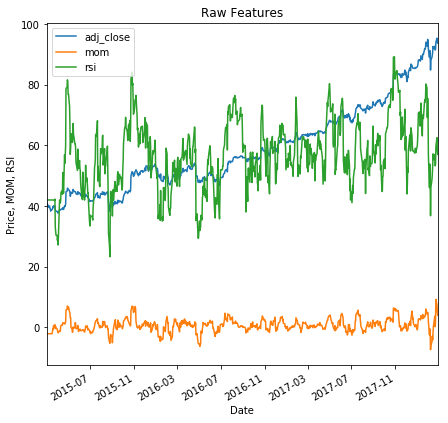

In [8]:
plot_data(data[["adj_close", "mom", "rsi"]], title="Raw Features", ylabel="Price, MOM, RSI") 

We can clearly see that three features adjusted close price, momentum and rsi have different ranges of values. In order to compare these properly, we need to normalize these features and then visualize. Normalization of features mainly done in order to make sure that algorithms treat the features equally. However normalization seem to be helpful for visualization. But just before we normalize we need to make sure that the derived metrics momentum and RSI do not have a highly skewed distribution. 

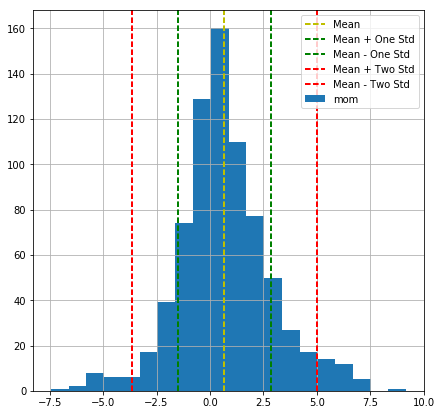

skewness = 0.189671476928
kurtosis = 1.30323675351


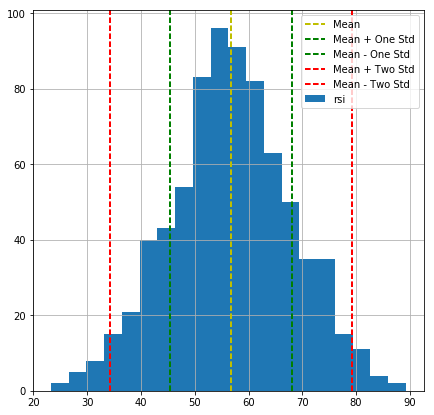

skewness = -0.0129745547362
kurtosis = -0.0984538898001


In [9]:
for col in ["mom", "rsi"]:
    plot_histogram(data[col], col)

From the histogram and results we can clearly that both rsi and mom have distribution that is close to normal. 

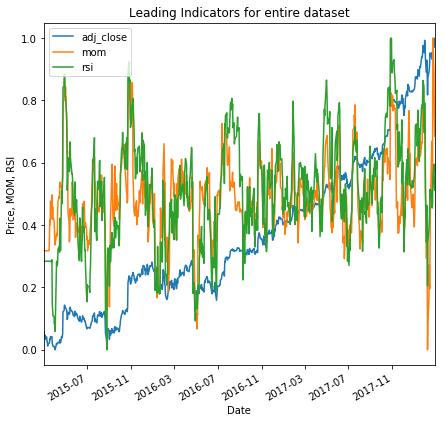

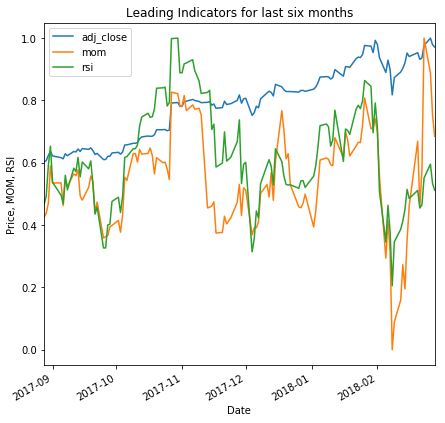

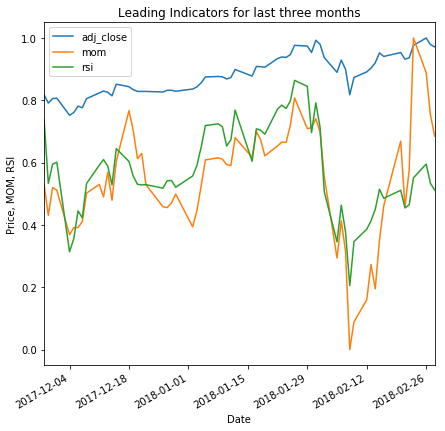

In [10]:
from sklearn.preprocessing import MinMaxScaler
def normalize_df(df):
    scaler = MinMaxScaler()
    # scaler = RobustScaler()
    data = scaler.fit_transform(df)
    # data = scaler.fit_transform(raw_features)
    normalized_df = pd.DataFrame(data=data, index=df.index.values, columns=df.columns.values)
    return normalized_df
# df, title="Raw Features", xlabel="Date", ylabel="Raw Features", kind='line'
plot_data(normalize_df(data[["adj_close", "mom", "rsi"]]), title="Leading Indicators for entire dataset", ylabel="Price, MOM, RSI")
plot_data(normalize_df(data[["adj_close", "mom", "rsi"]]).tail(126), title="Leading Indicators for last six months", ylabel="Price, MOM, RSI")
plot_data(normalize_df(data[["adj_close", "mom", "rsi"]]).tail(63), title="Leading Indicators for last three months", ylabel="Price, MOM, RSI")

Looking at the graph with full data, we can see that RSI and momentum follow each other very closely. However looking at the graphs with last six and three months we can see the difference between RSI and momentum. Momentum seems to oscillate more than rsi whenever there is a change in price movement. This could possibly be because of the fact the RSI considers average gains and average losses over a period of time, whereas momentum only considers the price. There is clear visual evidence in the third graph that RSI leads the adjusted close price between 2018-01-28 and 2018-02-12. Infact, RSI begins to lead the price even before momentum does in this period probably because of different time periods being considered for their calculation.

##### Simple,  Triangular and Weighted Moving Averages

Moving average is also called as rolling average where we add up the adjusted close prices for a particular time period and then we divide the total by that time period. The difference between these three moving average is the amount of weight that's being applied to them to calculate the average. Simple Moving Average considers that the entire series of data as equally important to calculate moving average whereas triangular and weighted moving averages give more weight to the middle and recent prices respectively.

##### Purpose/Significance of Using Moving Averages

Moving averages identify if a security's price is trending upwards or downwards.  This could be very helpful metric as we intend to predict adjusted close prices for a period of 7 days.  Moving averages could be used to generate buy and sell signals as well which is out of scope for this project.  For our problem, we can make use of the 20-day rolling period. 



In [11]:
from talib import SMA, TRIMA, WMA
n_days = 20
data["sma"] = SMA(adj_close, timeperiod=n_days)
data["trima"] = TRIMA(adj_close, timeperiod=n_days)
data["wma"] = WMA(adj_close, timeperiod=n_days)
fill_missing_values(data)
display(data.head(21))

,adj_open,adj_low,adj_high,adj_close,mom,rsi,sma,trima,wma
2015-03-02,40.767977,40.655951,41.253421,40.964022,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-03,40.665287,40.226520,40.912677,40.403894,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-04,40.151836,40.030475,40.338546,40.193846,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-05,40.207849,39.974462,40.366552,40.245191,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-06,40.142501,39.348986,40.245191,39.545031,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-09,39.386328,39.386328,40.259194,40.002469,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-10,39.535696,39.236961,39.871772,39.236961,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-11,39.498354,39.059587,39.554366,39.190283,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-12,38.583478,38.144711,38.882213,38.294079,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-13,37.995344,37.911325,38.714175,38.630155,-2.165828,41.987179,39.454477,39.308674,39.221468


Note that moving averages will also have NaN values intially just like momentum and RSI. We make use of pandas fillna function to handle this. Let's visualize the histogram for simple moving average only as all the three MA values are very close, so I expect the distribution to be very similar as well.

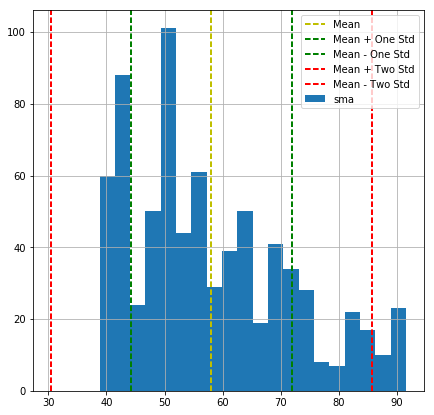

skewness = 0.67163073412
kurtosis = -0.411379857571


In [12]:
plot_histogram(data["sma"], "sma")

From the histogram and it's results we can see that this resembles the same positive skewness characteristic of the adjusted close price of the stock. This visualization clearly shows that simple moving average follows the price, which explains they have very similar distribution. 

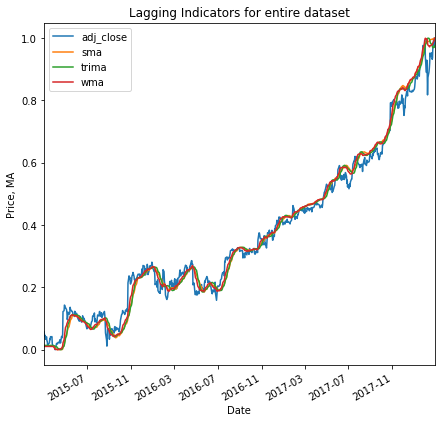

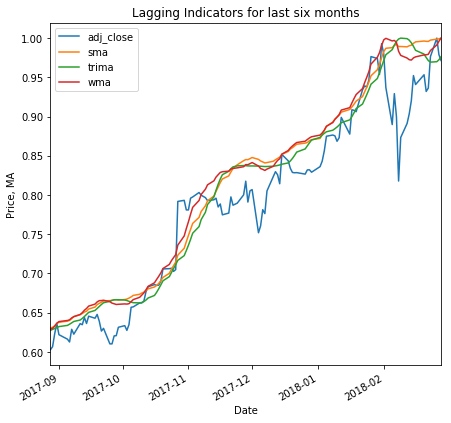

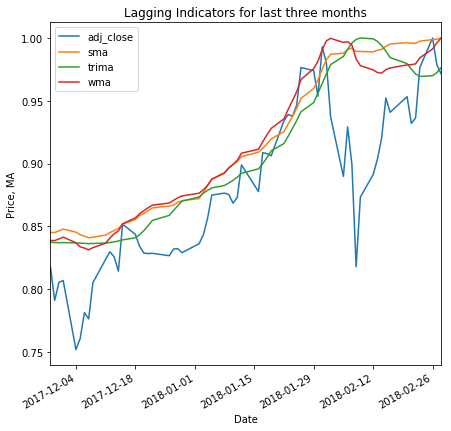

In [13]:
plot_data(normalize_df(data[["adj_close", "sma", "trima", "wma"]]), title="Lagging Indicators for entire dataset", ylabel="Price, MA")
plot_data(normalize_df(data[["adj_close", "sma", "trima", "wma"]]).tail(126), title="Lagging Indicators for last six months", ylabel="Price, MA")
plot_data(normalize_df(data[["adj_close", "sma", "trima", "wma"]]).tail(63), title="Lagging Indicators for last three months", ylabel="Price, MA")

We can see the difference between the three moving averages in the second and third graph. In the third graph the difference is more noticeble especially between 2018-01-28 and 2018-02-12. In this period we can notice that the weighted moving average starts to decline along with the price as it applies more weight to the recent prices, while the triangular moving average seem to incline and simple seems to level out /flat and then increase. This indicates that triangular takes more time to react to the price changes when compared to weighted and simple moving averages. Clearly there seems to be more lag for triangular moving average which give more weightage to the middle part of the time period. At the end we can see that the triangular moving is about to increase or start its uptrend while the other two averages have already reacted to the increase in price trend. Triangular moving average needs to be interpreted differently to other two moving averages especially when it's is volatile because of more lag. Now lets visualize all technical indicators for the last three months.

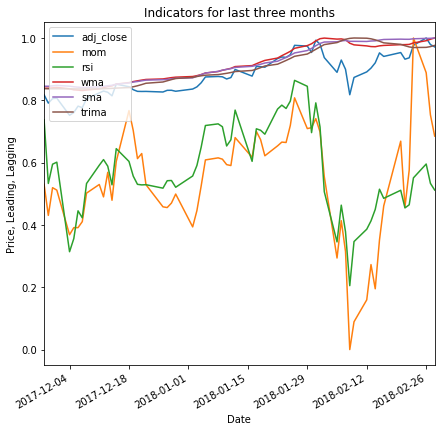

In [14]:
plot_data(normalize_df(data[["adj_close", "mom", "rsi", "wma","sma", "trima"]]).tail(63), title="Indicators for last three months", ylabel="Price, Leading, Lagging")

The above visualization shows the difference between leading and lagging indicators. We can see that the lagging indicators (moving averages) are less sensitive and decline gradually, while leading indicators (RSI and momentum) are tend to lead the price movements and naturally they are more sensitive to rapid price changes (volatile) that happens  between 2018-01-28 and 2018-02-12. Lets take a look at the complete dataset.

In [14]:
display(data.head())

,adj_open,adj_low,adj_high,adj_close,mom,rsi,sma,trima,wma
2015-03-02,40.767977,40.655951,41.253421,40.964022,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-03,40.665287,40.226520,40.912677,40.403894,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-04,40.151836,40.030475,40.338546,40.193846,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-05,40.207849,39.974462,40.366552,40.245191,-2.165828,41.987179,39.454477,39.308674,39.221468
2015-03-06,40.142501,39.348986,40.245191,39.545031,-2.165828,41.987179,39.454477,39.308674,39.221468


 All the metrics are numerical values. The dataset is time-series continuous data. 

### 4. Solution Statement

I would be using supervised learning regression algorithms to train the model as output to be predicted is a continuous value.

Since the output to be predicted is a continuous value, we need to make use of regression algorithms. 

#### Support Vector Machine

Support Vector Machine is a supervised learning algorithm. The ultimate goal of support vector machine is to maximize the robustness of the model, thereby producing a model that generalizes well. This idea of using SVM has been extended to solve regression problems.  

The cost function that is required to generate the model ignores any training data that is close to model prediction. SVR intends to minimize the deviation of data points that the curve fits.  Kernel functions make the SVM more versatile by offering different pattern analyses for different datasets. If the dataset is linearly separable then linear kernel could be used or RBF kernel could be used for non-linear regression as it fits a curve which could possibly generalize better. The available kernel functions for SVR are linear, RBF, polynomial, sigmoid and precomputed.  Apart from these, we could specify our own custom kernel functions. 
						
Although there are many kernel functions, I would be using linear and RBF kernels.  Radial Basis Function kernel creates non-linear combinations of features and then transforms them into high dimensional feature space to perform the linear separation. In RBF kernel we need to take care of two important parameters C and gamma to get the best of SVR.   In order to select the best combination of C and gamma, (which gives us the model that generalizes well) we use a technique called as grid search technique. This grid search technique could be used to optimize our learning algorithm by using a table which consists of columns with different kernels values (linear and polynomial) and rows with different exponential values of gamma.  Then, choose the model which has a better r2 (coefficient of determination) score. 


#### Multilayer Perceptron 

MLP is a supervised learning algorithm. MLP is a type of artificial neural network. ANN's are based on how the neurons in the human brain process information. Each neuron in a neural network receives it's input from other neurons or nodes and then computes the output.  
Each input contains an associated weight, which is based on the relative importance of itself to other inputs. Hence each node is a representation of the weighted sum of its inputs.
 
Output = f(W1X1 + W2X2 + ... + WnXn + b) 
		where W1, W2, Wn are associated weights
				X1, X2, Xn are inputs 
				b is bias.
				f is the activation function  that you apply to the above result. 

The purpose of having a bias is that gives a trainable constant value to each and every in order to get the desired output. Let's say for example if your desired output should have a minimum value of  1 and all your inputs are zeros. This would mean that your input of zeros will result in the output of 0 which makes this a linear function. For this purpose, if we have a bias in place then we would be able to get the desired output. Bias helps the network to generalize better.   

In real-world scenarios, we would come across many datasets which are non-linear. In order to address this, we make use of activation function.  For our problem, we would be using ReLu activation function (Rectified Linear Unit) and this is given by 
		 f(x) = max(0, x). 
By looking at the formula we can clearly see that it would discard the negatives values which is why it decides between 0 and some value x. It would choose the one that is greater. When traversing from one local maximum to minimum the gradient reduces exponentially resulting in negative activations and slow training. By applying ReLu to the entire set we make the training faster with less impact on the accuracy. ReLu activation function helps in reducing the training time and make computation much faster than other activation functions like sigmoid and tanh.  

MLP is a feed-forward neural network, meaning that information flows in one direction only. MLP contains three layers and they are input, hidden and output layers. No computation is performed in the input layer. Input layer passes the information that it gets from the previous node to the hidden. Hidden layers take care of the computations (activation function getting applied to the weighted sum of inputs) and transfer the computed information to the output layer. Further computations are performed in the output layer (like loss function) and then we finally get the output for MLP.  

The learning part of MLP is done by the backpropagation algorithm. Initially, the weights are assigned randomly. The output of MLP is compared to our desired output and the error gets propagated back to the previous layers and the weights are adjusted accordingly. The process is repeatedly performed until the error reduces below the threshold. In our case, we make use of square error as loss function and this explained below. 

#### Sklearn Implementation of MLP

MLP can learn a non-linear function approximator for a given a set of n features and a target as there can be one or more number of non-linear layers called as hidden layers which exist in between the input layer which contain n features and the output layer. Given a set of x features that form the input layer. These features could be thought of like a set of neurons in our brain. Each and every feature transforms the values from the previously hidden layer to the next one with a weighted linear summation W1X1 + W2X2 + ....  + WmXm and then followed by non-linear activation function g(.) : R ---> R -.  The output layer finally transforms the values received from the last hidden layer into the output.  MLP works well for non-linear models.  MLPRegressor trains the model using the backpropagation with no activation function in the output layer. This indirectly means that MLPRegressor would be identity function as the activation function. Hence it uses square error as loss function.

#### Kernel ridge regression

The model learned by KRR is identical to SVR but the difference lies in the loss functions.  SVR uses the epsilon-insensitive loss while uses squared error.  KRR is a combination of ridge regression (linear least squares with l2-norm regularization) and kernel trick.  When the dataset is medium size KRR could perform better than SVR. Since I am giving the option to choose the time period to train the stocks which will be discussed in project design.  As mentioned in the sklearn documentation,  fitting the kernel ridge is roughly seven times faster than SVR. However, SVR estimates better when the training set gets bigger. 

￼

### 5. Benchmark Model

Simple linear regression machine learning model is the benchmark that I would be comparing to the solution model to prove that this problem is solvable.

### 6. Evaluation Metrics

#### Coefficient of determination (r^2)

To determine how well the model fits the data we need to check if the differences between the actual observed values and the predicted values are small and unbiased. The coefficient of determination (r^2) is a statistical measure that explains the proportion of the variance in the dependent variable that is predictable from the independent variable.  It provides a measure of how well the predictions are done by the model for the future samples. Higher coefficient indicates that larger number of data points fall within the regression line.  The r-squared score of 0 indicates that none of the data points fall within the regression line, while 1 indicated that the regression line represents all data points and negative scores indicate that the model has poorly fitted the data. A higher coefficient is considered as the goodness of fit. The formula for R-squared is given by 


￼

### 7. Project Design

In order to build a stock price predictor, I would implement training, querying and removing interfaces.

#### Interfaces 

Training and querying interfaces would accept a list of stock ticker symbols and training/querying period. The minimum time period for training would be 5 years and maximum would be fifteen years.  The minimum and maximum time period for querying would 1 and 7 respectively, as my output is to predict the adjusted close price of the stock for the next seven days. The results of the predictions would be saved to a CSV file so that it would be easy to display the predictions when the user makes a query. Additionally, we provide removing interface which would remove all CSV files which contain predicted values for each stock ticker. In case if the user decides to train with different stock tickers or different time period, it would be easy to make use of this interface which would remove.  
                            Apart from the input metrics (adjusted open, adjusted low, adjusted high, adjusted close) we additionally add 5 technical indicators as mentioned in Datasets and Inputs section.  The distribution of the dataset and inputs has been addressed by visualizing the inputs. Analysis has also been performed for a stock ticker in section 3.(Datasets and Inputs)

#### Data Preprocessing

As rule of thumb skewness is considered as high if it is either greater than 1 (positive skewness) or lesser than -1 (negative skewness).  Algorithms are sensitive to skewed distribution hence transforming them becomes extremely important. In order to handle skewed distribution logarithmic transformation would be applied to make the distribution more normal and reduce the skewness. Since log of 0 is undefined, for negative values we take the absolute value, apply the logarithmic transformation and then multiply the transformed feature by -1.  Skewness verification function would be implemented to check the skewness for each and every feature and log transformation would be applied. After applying log transformations for the skewed features we then normalize the entire features in order to ensure that the algorithm treats all the features equally.  For this, we could make use of MinMaxScaler from the sklearn library. I have plotted graphs in the third section by applying this normalizer function. 

#### Model Training

The supervised algorithms that would be used for this task have been mentioned in section 4 (Solution statement).  When training the data points we need to split the data into training and testing sets in order to avoid bias. For this task, I would be using TimeSeriesSplit for splitting in order to avoid look ahead bias as we have to make predictions for time series continuous output. Cross-validation done in this is a variation of K Fold Cross Validator.  As mentioned in section 4 grid search technique would be applied to algorithms that have more than one hyperparameters( for SVR and KKR). Description of this technique has also been mentioned in section 4 ( solution statement ). 

#### Prediction

We make use of r-squared score to find the model that fits the data. For this, I could implement a function which takes the model that has the highest r-squared score when performing the grid search technique and make predictions for the next seven days. As mentioned earlier the predictions results would be saved to a CSV file. CSV file would contain the predictions made by our best model and the benchmark model.  Each stock ticker will have its own prediction CSV file. The name of the CSV file would be the name of the ticker.

#### List of Important Libraries that are being used for this project

1. Pandas (DataFrame data structure and its functions)
2. Numpy (Arrays, DateTime objects, Log Transformation)
3. Quandl (Stock data)
4.  TA-Lib (For computing Technical Indicators)
5. Sklearn  (MinMaxScaler, Algorithms, R-squared score, GridSearchCV, TimeSeriesSplit) 
6. Matplotlib (for plotting graphs and histograms)
7. Arrow (uses training period to figure out the start and end dates)  

Note:  A rough implementation of this project has been pushed to the repository which contains this proposal document. Please check this if you have time and provide the necessary feedback.  
